# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import model1
import data
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import torch

In [3]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
t,r,a,f

(34079637504, 0, 0, 0)

# Data

## Configuration

In [4]:
height = 512
width = 384
classes = {"cardboard":(0, 403),
        "glass":(1, 501),
        "metal":(2, 410),
        "paper":(3, 594),
        "plastic":(4, 482),
        "trash":(5, 137)}
skin_tones = {0:(41, 23, 9),#darker
              1:(95, 51, 16),
              2:(127, 68, 34),
              3:(178, 102, 68),
              4:(115, 63, 23),
              5:(147, 95, 55),
              6:(173, 138, 96),
              7:(207, 150, 95),
              8:(187, 101, 54),
              9:(212, 158, 122),
              11:(242, 194, 128),
              12:(236, 192, 145),
              13:(249, 212, 160),
              14:(248, 217, 152),
              15:(253, 231, 173),
              16:(254, 227, 197)}#paler

## Collection

# Model 1

### data load without mask

In [5]:
collector = data.DataCollector(height, width, classes)
datasets = collector.collect('trashnet/dataset-resized', val_size=0.2, test_size=0.2)

Store in X and y


In [6]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
t,r,a,f

(34079637504, 0, 0, 0)

## Construction

In [7]:
unique_filename_model1_unfreeze_1 = "seqno5_model1_train_final_layer"

In [8]:
model = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.001,
    bs = 64,
    rho = 0.9,
    gamma_step = 0.5,
    gamma = 0.9,
    num_active_layers = 5,
    free_all = False,
    if_replace = True,
    workers = 1,
    epochs = 25,
    mask = False,
    unique_filename = unique_filename_model1_unfreeze_1,
    model_type = 1,
    model_weights_ref_path = "ResNet34_Weights.pth"
    )

In [9]:
# summary(model.model, input_size=(model.batch_size, 3, model.height, model.width))

In [10]:
model.construct_data(datasets)

In [11]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
t,r,a,f

(34079637504, 113246208, 86162944, 27083264)

## Training

In [12]:
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model.train()

Epoch:   1 	 Training Loss: 1.64592 	 Training Accuracy: 0.32185 	 Validation Loss: 1.46758 	 Validation Accuracy: 0.46733
Epoch:   2 	 Training Loss: 1.34282 	 Training Accuracy: 0.50095 	 Validation Loss: 1.33091 	 Validation Accuracy: 0.49307
Epoch:   3 	 Training Loss: 1.19584 	 Training Accuracy: 0.55605 	 Validation Loss: 1.27292 	 Validation Accuracy: 0.51485
Epoch:   4 	 Training Loss: 1.08424 	 Training Accuracy: 0.62837 	 Validation Loss: 1.21966 	 Validation Accuracy: 0.53663
Epoch:   5 	 Training Loss: 0.98190 	 Training Accuracy: 0.66945 	 Validation Loss: 1.18544 	 Validation Accuracy: 0.55644
Epoch:   6 	 Training Loss: 0.89441 	 Training Accuracy: 0.71384 	 Validation Loss: 1.16064 	 Validation Accuracy: 0.54851
Epoch:   7 	 Training Loss: 0.81022 	 Training Accuracy: 0.75823 	 Validation Loss: 1.14602 	 Validation Accuracy: 0.56436
Epoch:   8 	 Training Loss: 0.73986 	 Training Accuracy: 0.78924 	 Validation Loss: 1.13736 	 Validation Accuracy: 0.56238
Epoch:   9 	 Tra

In [8]:
test_loss, test_accuracy = model.test()
test_loss, test_accuracy

(1.2446285486221313, tensor(0.4980))

In [19]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
t,r,a,f

(34079637504, 32277266432, 30071296512, 2205969920)

In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()

## unfreeze all the weights

In [30]:
unique_filename_model1_unfreeze_all = "seqno5_model1_unfreeze_all_layer"
model = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.0001,
    bs = 2,
    rho = 0.9,
    gamma_step = 0.5,
    gamma = 0.9,
    num_active_layers = 5,#doesn't matter
    free_all = False,
    if_replace = True,
    workers = 1,
    epochs = 25,
    mask = False,
    unique_filename = unique_filename_model1_unfreeze_all,
    model_type = 2,#the model to feed is  already modified to the num of class = 6
    model_weights_ref_path = f'models/{unique_filename_model1_unfreeze_1}/model.pth'
    )

In [31]:
model.construct_data(datasets)

In [32]:

_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.11 GiB (GPU 0; 31.74 GiB total capacity; 30.93 GiB already allocated; 238.88 MiB free; 31.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
test_loss, test_accuracy = model.test()
test_loss, test_accuracy

# Model2 with mask

## data collection with mask

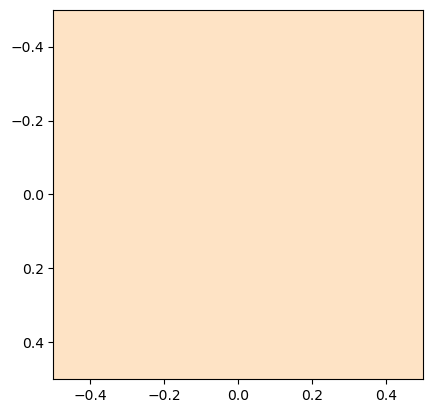

In [33]:
plt.imshow(np.expand_dims(np.array(skin_tones[16]),axis = (0,1)))
plt.show()

In [17]:
collector2 = data.DataCollector(height, width, classes,
                               mask_opts = {"mask_size":10,"skintone_label":15,
                               })
datasets2 = collector2.collect('trashnet/dataset-resized', val_size=0.2, test_size=0.2)

Store in X and y


In [20]:
model2 = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.001,
    bs = 32,
    rho = 0.9,
    gamma_step = 0.5,
    gamma = 0.9,
    num_active_layers = 5,
    if_replace = True,
    workers = 1,
    epochs = 25,
    mask = True,
    unique_filename = "seqno5_model2",
    model_type = 2,
    model_weights_ref_path = f'models/{unique_filename_model1_unfreeze_all}/model.pth'
    )

In [21]:
model2.construct_data(datasets2)

In [22]:
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model2.train()

Epoch:   1 	 Training Loss: 0.98364 	 Training Accuracy: 0.63429 	 Validation Loss: 1.19058 	 Validation Accuracy: 0.54653
Epoch:   2 	 Training Loss: 0.64310 	 Training Accuracy: 0.79421 	 Validation Loss: 1.14307 	 Validation Accuracy: 0.56436
Epoch:   3 	 Training Loss: 0.44638 	 Training Accuracy: 0.88855 	 Validation Loss: 1.13451 	 Validation Accuracy: 0.57822
Epoch:   4 	 Training Loss: 0.31374 	 Training Accuracy: 0.94614 	 Validation Loss: 1.13639 	 Validation Accuracy: 0.60000
Epoch:   5 	 Training Loss: 0.23369 	 Training Accuracy: 0.97508 	 Validation Loss: 1.14822 	 Validation Accuracy: 0.59010
Epoch:   6 	 Training Loss: 0.17641 	 Training Accuracy: 0.98603 	 Validation Loss: 1.15478 	 Validation Accuracy: 0.59802
Epoch:   7 	 Training Loss: 0.13240 	 Training Accuracy: 0.99094 	 Validation Loss: 1.17892 	 Validation Accuracy: 0.58812
Epoch:   8 	 Training Loss: 0.11565 	 Training Accuracy: 0.99450 	 Validation Loss: 1.19440 	 Validation Accuracy: 0.59406
Epoch:   9 	 Tra

In [23]:
test_loss, test_accuracy = model2.test()
test_loss, test_accuracy

(1.2986149787902832, tensor(0.5751))